# Advanced Visitor Forecasting & EDA (V4)
**Objective**: Train models on "Yearly Waterfall" data (2022-2025) and forecast Jan 2026.
**Structure**:
1.  Separate EDA for each year.
2.  Combined EDA.
3.  Feature Engineering.
4.  Model Training (Random Forest).
5.  14-Day Hourly Forecast.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings
warnings.filterwarnings('ignore')

# Config
DATA_DIR = '../datasets/advanced_hourly'
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)


## 1. Individual Year EDA

Loading 2022...
2022: 18250 rows


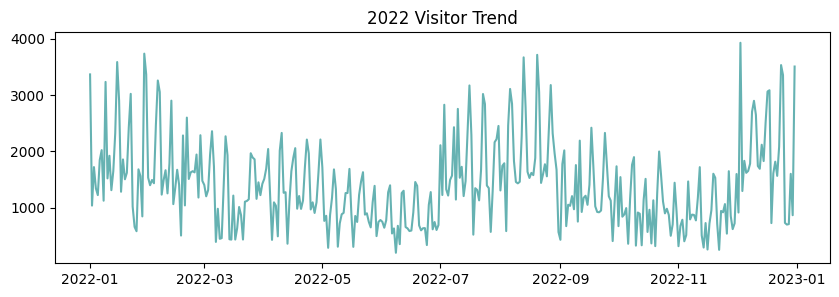

In [2]:
print("Loading 2022...")
try:
    df_2022 = pd.read_csv(f"{DATA_DIR}/visitor_dataset_2022.csv")
    df_2022['date'] = pd.to_datetime(df_2022['date'])
    print(f"2022: {len(df_2022)} rows")
    
    # Quick Plot
    daily_2022 = df_2022.groupby('date')['visitor_count'].sum()
    plt.figure(figsize=(10, 3))
    plt.plot(daily_2022, color='teal', alpha=0.6)
    plt.title(f"2022 Visitor Trend")
    plt.show()
except FileNotFoundError:
    print(f"Warning: 2022 file not found.")
    df_2022 = pd.DataFrame()


Loading 2023...


2023: 18250 rows


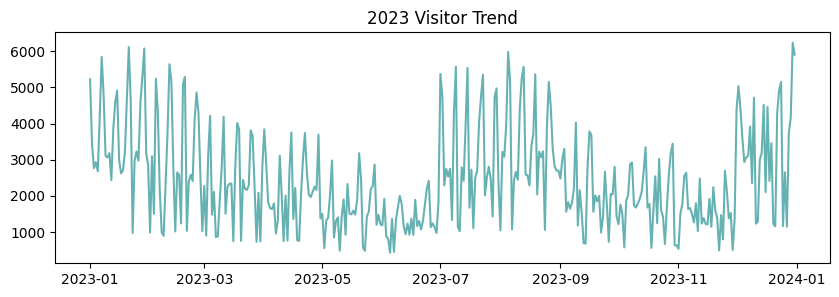

In [3]:
print("Loading 2023...")
try:
    df_2023 = pd.read_csv(f"{DATA_DIR}/visitor_dataset_2023.csv")
    df_2023['date'] = pd.to_datetime(df_2023['date'])
    print(f"2023: {len(df_2023)} rows")
    
    # Quick Plot
    daily_2023 = df_2023.groupby('date')['visitor_count'].sum()
    plt.figure(figsize=(10, 3))
    plt.plot(daily_2023, color='teal', alpha=0.6)
    plt.title(f"2023 Visitor Trend")
    plt.show()
except FileNotFoundError:
    print(f"Warning: 2023 file not found.")
    df_2023 = pd.DataFrame()


Loading 2024...
2024: 18300 rows


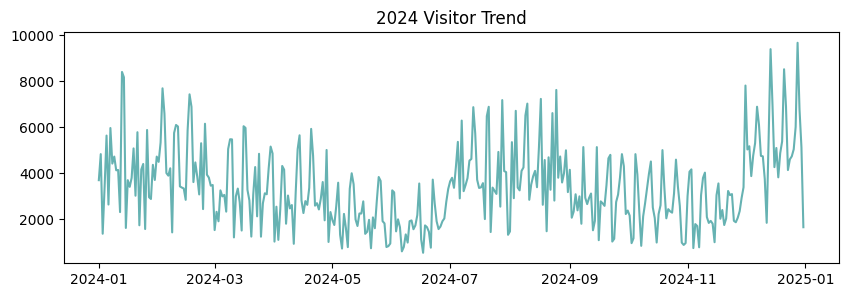

In [4]:
print("Loading 2024...")
try:
    df_2024 = pd.read_csv(f"{DATA_DIR}/visitor_dataset_2024.csv")
    df_2024['date'] = pd.to_datetime(df_2024['date'])
    print(f"2024: {len(df_2024)} rows")
    
    # Quick Plot
    daily_2024 = df_2024.groupby('date')['visitor_count'].sum()
    plt.figure(figsize=(10, 3))
    plt.plot(daily_2024, color='teal', alpha=0.6)
    plt.title(f"2024 Visitor Trend")
    plt.show()
except FileNotFoundError:
    print(f"Warning: 2024 file not found.")
    df_2024 = pd.DataFrame()


Loading 2025...
2025: 18250 rows


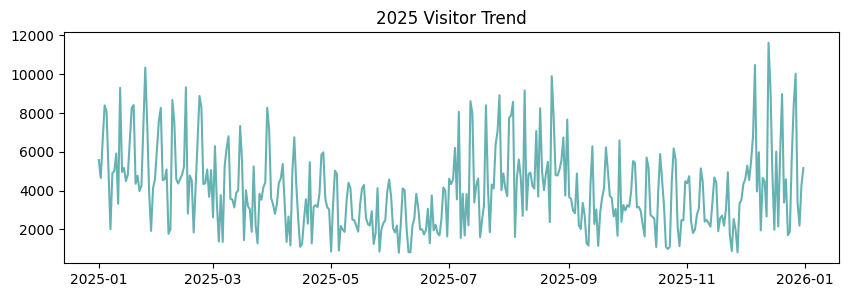

In [5]:
print("Loading 2025...")
try:
    df_2025 = pd.read_csv(f"{DATA_DIR}/visitor_dataset_2025.csv")
    df_2025['date'] = pd.to_datetime(df_2025['date'])
    print(f"2025: {len(df_2025)} rows")
    
    # Quick Plot
    daily_2025 = df_2025.groupby('date')['visitor_count'].sum()
    plt.figure(figsize=(10, 3))
    plt.plot(daily_2025, color='teal', alpha=0.6)
    plt.title(f"2025 Visitor Trend")
    plt.show()
except FileNotFoundError:
    print(f"Warning: 2025 file not found.")
    df_2025 = pd.DataFrame()


## 2. Combined EDA & Feature Engineering

In [6]:
# Merge
full_df = pd.concat([df_2022, df_2023, df_2024, df_2025], ignore_index=True)
print(f"Full Dataset: {len(full_df)} rows")

# Features
full_df['date'] = pd.to_datetime(full_df['date'])
full_df['day_of_year'] = full_df['date'].dt.dayofyear
full_df['month'] = full_df['date'].dt.month
full_df['dow'] = full_df['date'].dt.dayofweek
full_df['is_weekend'] = (full_df['dow'] >= 5).astype(int)
full_df['hour_int'] = full_df['hour'].str.split(':').str[0].astype(int)

# Encoding (One-Hot for Location/Event to preserve nuances)
df_model = pd.get_dummies(full_df, columns=['location', 'event_name'], drop_first=False)

# Select Features
exclude = ['date', 'hour', 'visitor_count', 'weather'] # excluding weather for forecast simplicity
features = [c for c in df_model.columns if c not in exclude]

print(f"Training Features ({len(features)}): {features[:5]} ...")
X = df_model[features]
y = df_model['visitor_count']


Full Dataset: 73050 rows


Training Features (15): ['day_of_year', 'month', 'dow', 'is_weekend', 'hour_int'] ...


## 3. Model Training

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
print(f"R2: {r2_score(y_test, preds):.4f}")

# Save Model
joblib.dump(model, f"{MODEL_DIR}/admin_hourly_model.pkl")
# Save Feature Columns (Critical for prediction alignment)
joblib.dump(features, f"{MODEL_DIR}/model_features.pkl")
print("Model & Features Saved.")


MAE: 20.86
R2: 0.7566


Model & Features Saved.


## 4. Next 14 Days Forecast

In [8]:
# Setup Future DataFrame
last_date = full_df['date'].max()
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 15)]
hours = range(8, 18)
locations = full_df['location'].unique()

rows = []

# Helper for Event Logic (matches generator)
def get_event(loc, h):
    if loc == "Elephant Bathing Area":
        return "River Bathing" if h in [10, 11, 14, 15] else "River Observation"
    if loc == "Milk Feeding Nursery":
        return "Bottle Feeding" if h in [9, 13, 17] else "Closed"
    if loc == "Main Entrance":
        return "Entry"
    if loc == "Souvenir Shop":
        return "Shopping"
    return "General Visit"

print("Generating Future Inputs...")

for date in future_dates:
    for h in hours:
        for loc in locations:
            event = get_event(loc, h)
            
            # Base features
            row = {
                'day_of_year': date.dayofyear,
                'month': date.month,
                'dow': date.dayofweek,
                'is_weekend': int(date.dayofweek >= 5),
                'hour_int': h
            }
            
            # One-Hot Columns (Set 1 or 0)
            # Init all dummy columns to 0
            for feat in features:
                if feat not in row:
                    row[feat] = 0
            
            # Set Active Dummies
            if f"location_{loc}" in row: row[f"location_{loc}"] = 1
            if f"event_name_{event}" in row: row[f"event_name_{event}"] = 1
            
            # Metadata for result
            row['date'] = date
            row['hour'] = f"{h:02d}:00"
            row['location'] = loc
            row['event'] = event
            
            rows.append(row)

pred_df = pd.DataFrame(rows)

# Predict
X_future = pred_df[features]
pred_df['predicted_visitors'] = model.predict(X_future).astype(int)

# Clean Output
output = pred_df[['date', 'hour', 'location', 'event', 'predicted_visitors']]
print(output.head())

# Save
output.to_csv(f"{DATA_DIR}/forecast_14_days.csv", index=False)
print("Forecast Saved.")


Generating Future Inputs...
        date   hour               location              event  \
0 2026-01-01  08:00          Main Entrance              Entry   
1 2026-01-01  08:00  Elephant Bathing Area  River Observation   
2 2026-01-01  08:00   Milk Feeding Nursery             Closed   
3 2026-01-01  08:00                 Museum      General Visit   
4 2026-01-01  08:00          Souvenir Shop           Shopping   

   predicted_visitors  
0                  72  
1                  35  
2                  60  
3                  41  
4                  16  
Forecast Saved.
